# Assignment 6 - Graph drawing and network analysis

In this assignment you will get to work with graphs using the [graph-tool python module](https://graph-tool.skewed.de/).

Learning goals are:

* perform basic network analysis to create derived graph properties,
* visualize graphs and their properties.

If you require an introduction to basic graph notions, consider to read the so-titled section in [Maël Fabien
's introductory blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5). While graph theory and algorithms can lead to fairly deep mathematical discussion, basic definitions and much practical use of graph data are quite easy to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and the [tutorial notebook](https://stevenbergner.github.io/Teaching/cmpt767/graph-tool-tutorial-todo.ipynb). See the [lab setup](#Environment-setup) section below to learn about the `gt conda` environment that has all required dependencies installed in the Big Data Lab.

In [1]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

graph-tool version: 2.29


# Problem 1: Power grid analysis

In [2]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

 In this graph an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

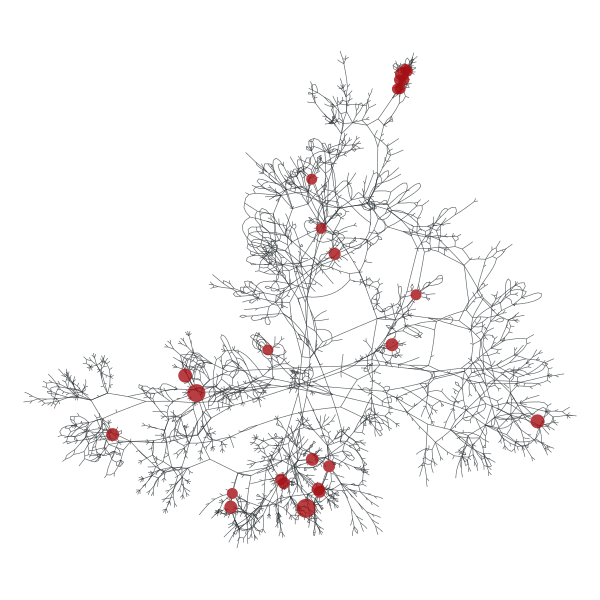

In [8]:
# create a new vertex property
v_count_p = g.new_vertex_property('int')

# iterate all vertices
for vertex in g.vertices():
    
    if (vertex.out_degree() > 10):
        # set value to # of supply lines if >= 10
        v_count_p[vertex] = vertex.out_degree()
    else:
        # otherwise set to 0
        v_count_p[vertex] = 0

# set property to graph vertices
g.vp['count'] = v_count_p

# draw graph
SIZE=600
EDGE_PEN_WIDTH = SIZE / 1000
gt.graph_draw(g, output_size=(SIZE,SIZE), 
              vertex_size=g.vp['count'], 
              edge_pen_width=EDGE_PEN_WIDTH);

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

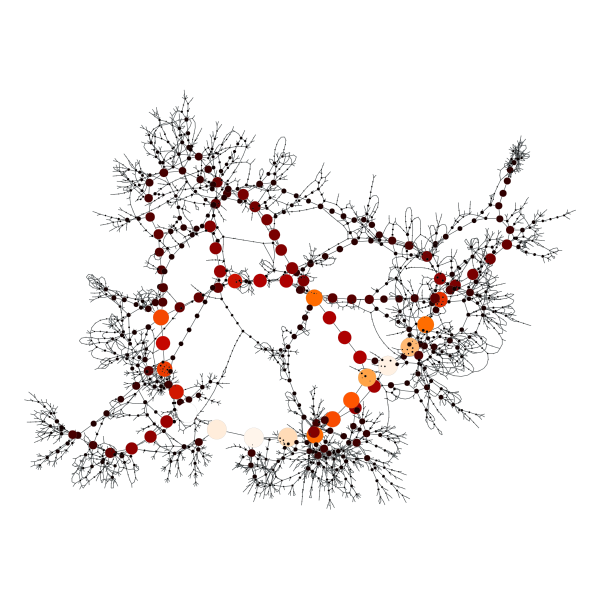

In [9]:
# get betweenness for vertices and edges
vp, ep = gt.betweenness(g)

# draw graph
SIZE=600
EDGE_PEN_WIDTH = SIZE / 1000
gt.graph_draw(g, output_size=(SIZE,SIZE), 
              vertex_size=gt.prop_to_size(vp, 0, 20),
              vertex_fill_color=vp,
              vcmap=matplotlib.cm.gist_heat,
              edge_pen_width=EDGE_PEN_WIDTH);

# Problem 2: Small social graph visualization

In [10]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph based on the information above, remove parallel edges, and draw it using a layout that resembles the tidy example given below.

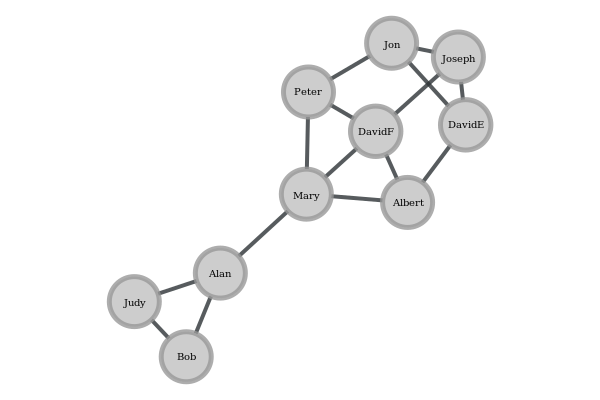

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe24c2bd8d0, at 0x7fe24c2b6cc0>

In [13]:
import graph_tool.util as util

# create graph
social_graph = gt.Graph(directed=False)

# create vertex property for keeping names
v_name_p = social_graph.new_vertex_property('string')
social_graph.vp['name'] = v_name_p

# iterate through dictionary keys
for person1 in X_knows:
    
    # check if vertex added before
    v1 = util.find_vertex(social_graph, social_graph.vp['name'], person1)
    
    # if not added
    if (len(v1) == 0):
        # add vertex
        v1 = social_graph.add_vertex()
        v_name_p[v1] = person1
    else:
        # otherwise, get found vertex
        v1 = v1[0]
        
    # iterate through each person contacts
    for person2 in X_knows[person1]:
        
        # check if vertex added before
        v2 = util.find_vertex(social_graph, social_graph.vp['name'], person2)
        
        # if not added
        if (len(v2) == 0):
            # add vertex
            v2 = social_graph.add_vertex()
            v_name_p[v2] = person2
        else:
            # otherwise, get found vertex
            v2 = v2[0]

        # if no edge exists between two vertices, add new edge
        if (social_graph.edge(v1, v2) is None):
            social_graph.add_edge(v1, v2)

# draw graph
SIZE_WIDTH=600
SIZE_HEIGHT=400
EDGE_PEN_WIDTH = SIZE / 150
VERTEX_FONT_SIZE = 10
VERTEX_SIZE = 50
VERTEX_COLOR = '#CDCDCD'

gt.graph_draw(social_graph, 
              vertex_text=social_graph.vp['name'], 
              edge_pen_width=EDGE_PEN_WIDTH, 
              output_size=(SIZE_WIDTH,SIZE_HEIGHT),
              vertex_fill_color=VERTEX_COLOR,
              vertex_font_size=VERTEX_FONT_SIZE,
              vertex_size=VERTEX_SIZE)

# Problem 3: Facebook graph analysis

For the following question let us work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. the friends of each of these users and the connections among those friends.

Goal of the following questions is to use centrality measures to determine influencers among the users, not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [14]:
# I first created graph manually
'''
df_edges = pd.read_csv('facebook_combined.txt', delimiter=' ',names=['v1','v2'])

fb_graph = gt.Graph(directed=False)

max_v1 = df_edges['v1'].max()
max_v2 = df_edges['v2'].max()

fb_graph.add_vertex(1 + max(max_v1, max_v2))

for idx,row in df_edges.iterrows():
    user1 = row['v1']
    user2 = row['v2']
    
    v1 = fb_graph.vertex(user1)
    v2 = fb_graph.vertex(user2)
    
    fb_graph.add_edge(v1, v2)
'''

# then realized that there's function for this
fb_graph = gt.load_graph_from_csv('facebook_combined.txt', 
                                  directed=False, 
                                  csv_options={'delimiter': ' '})

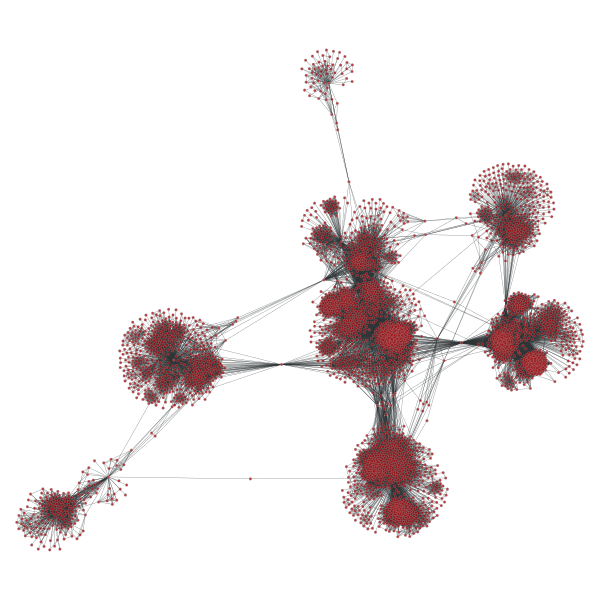

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe24c2b2f28, at 0x7fe25c331048>

In [15]:
# draw graph
SIZE = 600
gt.graph_draw(fb_graph,output_size=(SIZE,SIZE))

**Task 3b:** Calculate and show a histogram of pairwise distances among users, i.e. on the shortest paths of friendship connections among any pair of users. Use a log-scale to show the frequencies in the histogram. What is the diameter of this graph?

*Hint:* Calculating and drawing the histogram amounts to two lines of code using `gt` and `plt` modules.

(array([1.970e+02, 6.800e+01, 1.278e+03, 1.380e+03, 8.890e+02, 1.990e+02,
        2.300e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 PropertyArray([0.17825454, 0.20639903, 0.23454352, 0.26268801, 0.2908325 ,
                0.31897699, 0.34712149, 0.37526598, 0.40341047, 0.43155496,
                0.45969945]),
 <a list of 10 Patch objects>)

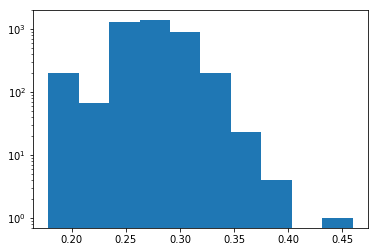

In [16]:
# TODO
vp = gt.closeness(fb_graph).a
plt.hist(vp, log=True)

**Task 3c:** Determine influencers, i.e. people withing the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) and drawing that only retains nodes with a `pagerank` $< 0.002$.

In [18]:
# get page rank
v_rank_p = gt.pagerank(fb_graph)
fb_graph.vp['s1_rank'] = v_rank_p

# filter page rank < 0.0002 and create a view from remaining nodes
gv_s1 = gt.GraphView(fb_graph, vfilt=fb_graph.vp['s1_rank'].a < 0.002)

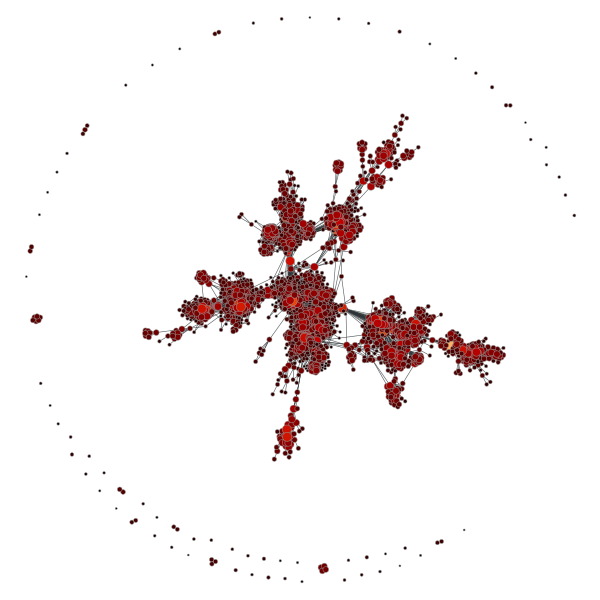

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe243043470, at 0x7fe24c1abef0>

In [19]:
# draw graph
SIZE = 600
MIN_V_SIZE = 2
MAX_V_SIZE = 15
MIN_VF_COL = 0
MAX_VF_COL = 10

gt.graph_draw(gv_s1, output_size=(SIZE, SIZE),
              vertex_size=gt.prop_to_size(gv_s1.vp['s1_rank'], MIN_V_SIZE, MAX_V_SIZE),
              vertex_fill_color=gt.prop_to_size(gv_s1.vp['s1_rank'], MIN_VF_COL, MAX_VF_COL),
              vcmap=matplotlib.cm.gist_heat)

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

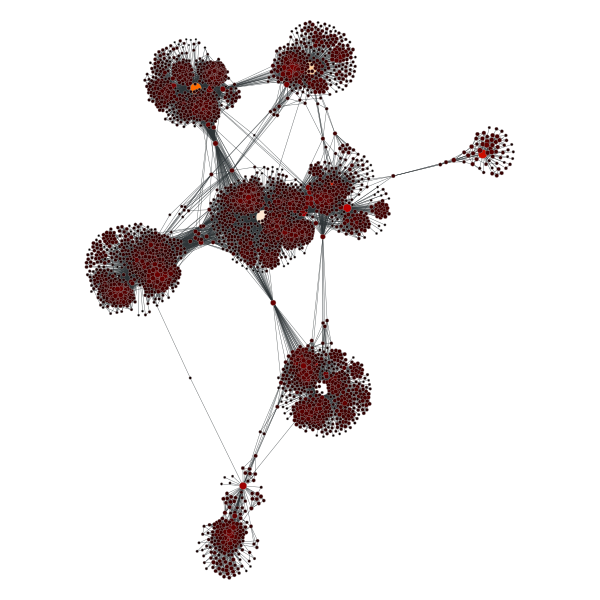

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe243015b70, at 0x7fe24311f898>

In [20]:
# get largest component
fb_con_grph = gt.extract_largest_component(fb_graph)

# create a view from that
gv_s2 = gt.GraphView(fb_con_grph)

# draw graph
SIZE = 600
MIN_V_SIZE = 2
MAX_V_SIZE = 15
MIN_VF_COL = 0
MAX_VF_COL = 10

gt.graph_draw(gv_s2, output_size=(SIZE, SIZE),
              vertex_size=gt.prop_to_size(gv_s2.vp['s1_rank'], MIN_V_SIZE, MAX_V_SIZE),
              vertex_fill_color=gt.prop_to_size(gv_s2.vp['s1_rank'], MIN_VF_COL, MAX_VF_COL),
              vcmap=matplotlib.cm.gist_heat)

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that potentially play central roles among their friends.

In [22]:
# get page ranks
v_rank_p = gt.pagerank(fb_graph)

# set those <= threshold to 0
v_rank_p.a[v_rank_p.a < 0.00055] = 0

# set to vertices property
fb_graph.vp['s3_rank'] = v_rank_p

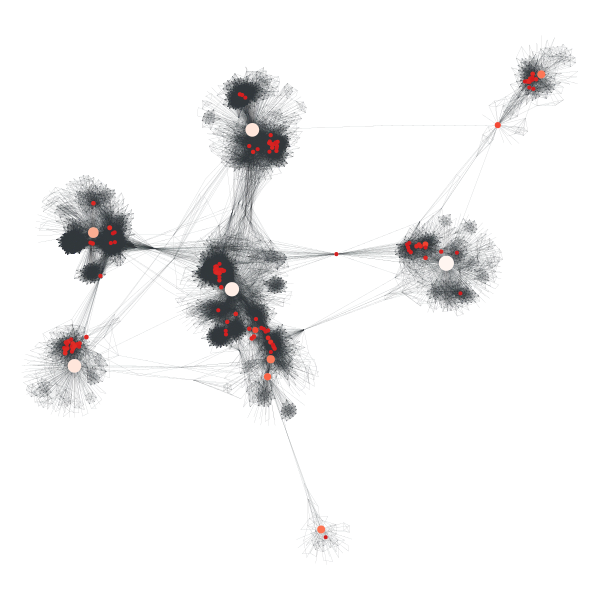

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe24c2b2f28, at 0x7fe1fb698e48>

In [23]:
# draw graph
SIZE = 600
MIN_V_SIZE = 0
MAX_V_SIZE = 15
MIN_VF_COL = 1
MAX_VF_COL = 15
EDGE_PEN_WIDTH = 0.08

gt.graph_draw(fb_graph, output_size=(SIZE, SIZE),
              vertex_size=gt.prop_to_size(fb_graph.vp['s3_rank'], MIN_V_SIZE, MAX_V_SIZE),
              vertex_fill_color=gt.prop_to_size(fb_graph.vp['s3_rank'], MIN_VF_COL, MAX_VF_COL),
              edge_pen_width=EDGE_PEN_WIDTH,
              vcmap=matplotlib.cm.Reds_r)

# Environment setup

## Lab setup
We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/gt
```
You should now be able to `import graph_tool` in a python 3 session or inside jupyter notebooks.

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
conda init bash
conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

#### Reproduce the conda setup in the lab

In case you want to reproduce the setup, here are the calls used to create the environment:
```
conda create -n gt
conda activate gt
conda install -c conda-forge graph-tool
conda install -c pkgw-forge -c conda-forge gtk3 pygobject
conda install -c conda-forge jupyter jupyterlab
conda install -c conda-forge matplotlib scikit-learn seaborn networkx igraph pyintergraph graphviz
```


## Setup on Linux (Ubuntu or WSL)

If you have sudo privileges, you can simply run
```
sudo apt install python3-graph-tool
```
and proceed to install further Python dependencies via `pip`, not requiring anaconda.
In case there are issues with drawing functionality, you may also need
```
sudo install libcairo2-dev xdg-utils graphviz
```

Note, that this also works on Windows' WSL (Windows Sub-shell for Linux) running Ubuntu, in case you do not want to launch a VM for this.

## Other environments and remote use

Setting up `graph_tool` on Mac OSX is possible via `brew`, but evidence online suggests that this may not be straightforward.
Since the [conda-forge graph-tool package](https://anaconda.org/conda-forge/graph-tool) is available for `osx-64`, maybe you want to try installing via `conda` instead of `brew`.

Remote use of the lab setup is possible, but tricky. Familiarize yourself with a shell session manager, such as [`tmux`](https://tmuxcheatsheet.com/) or GNU [`screen`](https://gist.github.com/fredrick/1216878) to keep an ssh session open once you logged into a lab machine. To connect to a jupyter notebook remotely you could create a [`ngrok`](https://ngrok.com/) account and use their http port tunneling. If you have questions about this method, ask Steven in the lab for more hints.


# Submission instructions
Please submit [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) with filled out code cells and figures included to [CourSys activity A6](https://coursys.sfu.ca/2020sp-cmpt-733-g1/+a6/).